In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Ensure same preprocessing as previous script
def advanced_text_preprocessing(content):
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()
    # Convert to lowercase and remove special characters
    lemmatized_content = re.sub(r'http\S+|www\S+|https\S+', '', content, flags=re.MULTILINE)  # Remove URLs
    lemmatized_content = re.sub(r'@\w+|\#', '', lemmatized_content)  # Remove mentions and hashtag symbols
    lemmatized_content = re.sub(r'[^a-zA-Z\s]', '', lemmatized_content)  # Remove numbers and punctuation
    lemmatized_content = lemmatized_content.lower()

    # Tokenization
    words = word_tokenize(lemmatized_content)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'rt', 'via'}
    stop_words.update(custom_stopwords)
    processed_words = [
        lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2
    ]
    lemmatized_content = ' '.join(processed_words)
    return lemmatized_content

In [3]:
def load_data():
    """Load and preprocess the Twitter dataset"""
    # column_names = ['text','target' ]
    data = pd.read_csv("IMDB_Dataset.csv", encoding='ISO-8859-1')
    # data['target'] = data['target'].replace("positive", 1)
    # data['target'] = data['target'].replace("negative", 0)
    return data

In [4]:
def create_deep_learning_model(vocab_size, max_length):
    """Create a deep learning model with LSTM layers"""
    model = Sequential([
        # Embedding layer to convert words to dense vector representations
        Embedding(vocab_size, 100, input_length=max_length),

        # LSTM layer with dropout for regularization
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),

        # Additional dense layers with dropout
        Dense(64, activation='relu'),
        Dropout(0.5),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [5]:
def prepare_deep_learning_data(texts, max_words=5000, max_length=100):
    """Prepare text data for deep learning model"""
    # Tokenize the text
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)

    # Convert text to sequences
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    return padded_sequences, tokenizer

In [6]:
def train_deep_learning_model(X_train, y_train, X_test, y_test):
    """Train and evaluate deep learning model"""
    # Prepare data
    max_words = 5000
    max_length = 100

    # Prepare sequences
    X_train_seq, tokenizer = prepare_deep_learning_data(X_train, max_words, max_length)
    X_test_seq, _ = prepare_deep_learning_data(X_test, max_words, max_length)

    # Ensure binary targets
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    # Create and compile model
    vocab_size = len(tokenizer.word_index) + 1
    model = create_deep_learning_model(vocab_size, max_length)

    # Train the model
    history = model.fit(
        X_train_seq, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate the model
    train_pred = (model.predict(X_train_seq) > 0.5).astype(int).flatten()
    test_pred = (model.predict(X_test_seq) > 0.5).astype(int).flatten()

    results = {
        'Deep Learning Model': {
            'train_accuracy': accuracy_score(y_train, train_pred),
            'test_accuracy': accuracy_score(y_test, test_pred),
            'classification_report': classification_report(y_test, test_pred)
        }
    }

    return results, model, tokenizer

In [7]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
# Load and preprocess data

print("Loading and preprocessing data...")
data = load_data()

Loading and preprocessing data...


In [10]:
data['target'] = data['sentiment'].replace('positive', 1).replace('negative', 0)

C:\Users\nikhi\AppData\Local\Temp\ipykernel_54316\3214355603.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['target'] = data['sentiment'].replace('positive', 1).replace('negative', 0)


In [12]:
data = data.dropna()

In [13]:
# counting the num of missing values in the dataset
data.isnull().sum()

review       0
sentiment    0
target       0
dtype: int64

In [19]:
# checking the distribution of target col

data['target'].value_counts()

target
1    25000
0    25000
Name: count, dtype: int64

In [18]:
data.head()

,review,sentiment,target,lemmatized_content
0,One of the other reviewers has mentioned that ...,positive,1,one reviewer mentioned watching episode youll ...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter matteis love time money visually stunni...


In [15]:
# Preprocess text
# apply on 30k data
# data = data.sample(n=10000, random_state=42)

data['lemmatized_content'] = data['review'].apply(advanced_text_preprocessing)

In [17]:
# Ensure target column contains only integers
data['target'] = pd.to_numeric(data['target'], errors='coerce')  # Convert to numeric, NaN for invalid
data = data.dropna(subset=['target'])  # Drop rows where target conversion failed
data['target'] = data['target'].astype(int)  # Convert to integers


In [20]:
data.head(200)

,review,sentiment,target,lemmatized_content
0,One of the other reviewers has mentioned that ...,positive,1,one reviewer mentioned watching episode youll ...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter matteis love time money visually stunni...
...,...,...,...,...
195,Phantasm ....Class. Phantasm II.....awesome. P...,negative,0,phantasm class phantasm iiawesome phantasm iii...
196,Ludicrous. Angelic 9-year-old Annakin turns in...,negative,0,ludicrous angelic yearold annakin turn whiny b...
197,"Scotty (Grant Cramer, who would go on to star ...",negative,0,scotty grant cramer would star great bmovie ki...
198,If you keep rigid historical perspective out o...,positive,1,keep rigid historical perspective film actuall...


In [21]:
X = data['lemmatized_content'].values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [22]:
# Train deep learning model
print("Training deep learning model...")

dl_results, dl_model, tokenizer = train_deep_learning_model(X_train, y_train, X_test, y_test)

Training deep learning model...
Epoch 1/10


C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 86s 83ms/step - accuracy: 0.5313 - loss: 0.6857 - val_accuracy: 0.6173 - val_loss: 0.6341
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.6641 - loss: 0.6156 - val_accuracy: 0.7746 - val_loss: 0.5170
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 83ms/step - accuracy: 0.7726 - loss: 0.5116 - val_accuracy: 0.8124 - val_loss: 0.4337
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.8342 - loss: 0.3955 - val_accuracy: 0.8439 - val_loss: 0.3512
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.8654 - loss: 0.3288 - val_accuracy: 0.8472 - val_loss: 0.3492
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.8905 - loss: 0.2803 - val_accuracy: 0.8309 - val_loss: 0.3708
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 84s 84ms/step - accuracy: 0.8923 - loss: 0.2687 - val_accuracy: 0.8524 - val_loss: 0.3552
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.9083 - loss: 0.23

In [23]:
for model_name, metrics in dl_results.items():
        print(f"\n{model_name} Results:")
        print(f"Training Accuracy: {metrics['train_accuracy']:.4f}")
        print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
        print("\nClassification Report:")
        print(metrics['classification_report'])


Deep Learning Model Results:
Training Accuracy: 0.9419
Test Accuracy: 0.4952

Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50      5000
         1.0       0.50      0.49      0.49      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels):
    """Plot the confusion matrix using seaborn"""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


In [25]:
from sklearn.metrics import confusion_matrix

def train_deep_learning_model(X_train, y_train, X_test, y_test):
    """Train and evaluate deep learning model with confusion matrix"""
    # Prepare data
    max_words = 5000
    max_length = 100

    # Prepare sequences
    X_train_seq, tokenizer = prepare_deep_learning_data(X_train, max_words, max_length)
    X_test_seq, _ = prepare_deep_learning_data(X_test, max_words, max_length)

    # Ensure binary targets
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    # Create and compile model
    vocab_size = len(tokenizer.word_index) + 1
    model = create_deep_learning_model(vocab_size, max_length)

    # Train the model
    history = model.fit(
        X_train_seq, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate the model
    train_pred = (model.predict(X_train_seq) > 0.5).astype(int).flatten()
    test_pred = (model.predict(X_test_seq) > 0.5).astype(int).flatten()

    # Confusion matrix for test data
    cm = confusion_matrix(y_test, test_pred)

    results = {
        'Deep Learning Model': {
            'train_accuracy': accuracy_score(y_train, train_pred),
            'test_accuracy': accuracy_score(y_test, test_pred),
            'classification_report': classification_report(y_test, test_pred),
            'confusion_matrix': cm.tolist()  # Convert to list for readability
        }
    }

    return results, model, tokenizer


Epoch 1/10


C:\Users\nikhi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - accuracy: 0.5257 - loss: 0.6893 - val_accuracy: 0.6345 - val_loss: 0.6483
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.6211 - loss: 0.6610 - val_accuracy: 0.6610 - val_loss: 0.6314
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.7006 - loss: 0.5928 - val_accuracy: 0.8226 - val_loss: 0.3986
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.8540 - loss: 0.3697 - val_accuracy: 0.8554 - val_loss: 0.3415
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.8824 - loss: 0.3044 - val_accuracy: 0.8570 - val_loss: 0.3452
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9008 - loss: 0.2659 - val_accuracy: 0.8580 - val_loss: 0.3327
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9140 - loss: 0.2295 - val_accuracy: 0.8611 - val_loss: 0.3388
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9291 - loss: 0.20

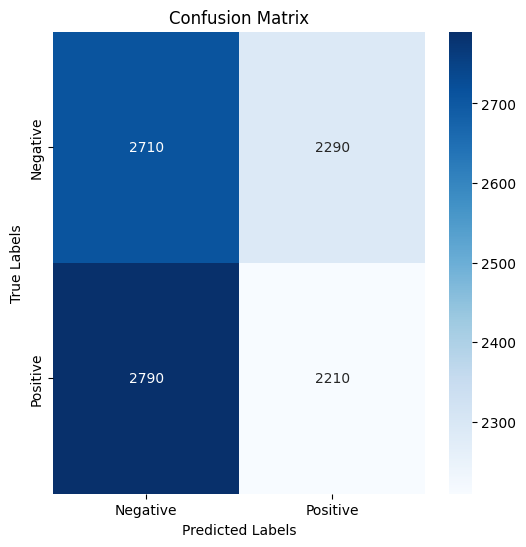

In [26]:
# Train the model and get results
results, model, tokenizer = train_deep_learning_model(X_train, y_train, X_test, y_test)

# Extract confusion matrix
confusion_matrix_data = results['Deep Learning Model']['confusion_matrix']
print("Confusion Matrix:\n", confusion_matrix_data)

# Visualize confusion matrix
plot_confusion_matrix(confusion_matrix_data, labels=["Negative", "Positive"])


In [22]:
import pickle

In [23]:
with open('model.pkl', 'wb') as file:  # 'wb' means write in binary mode
    pickle.dump(model, file)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Test Accuracy: 0.49

Classification Report:
               precision    recall  f1-score   support

    Negative       0.49      0.54      0.52      5000
    Positive       0.49      0.44      0.47      5000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



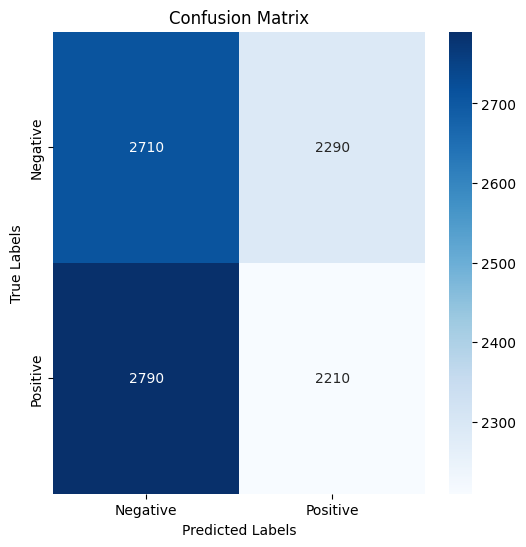

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels):
    """Plot the confusion matrix using seaborn"""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the model on the test dataset
def evaluate_model(model, X_test_seq, y_test):
    # Generate predictions
    y_pred = (model.predict(X_test_seq) > 0.5).astype(int).flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
    cm = confusion_matrix(y_test, y_pred)

    # Display results
    print(f"Test Accuracy: {accuracy:.2f}")
    print("\nClassification Report:\n", report)

    # Plot confusion matrix
    plot_confusion_matrix(cm, labels=["Negative", "Positive"])

# Prepare test data sequences
max_words = 5000
max_length = 100
X_test_seq, _ = prepare_deep_learning_data(X_test, max_words, max_length)

# Test and evaluate the model
evaluate_model(model, X_test_seq, y_test)


# Sentiment Analysis Model Performance Report

## Executive Summary

This report provides a comprehensive analysis of a deep learning-based sentiment analysis model trained on the IMDB movie review dataset, highlighting its performance, challenges, and key insights.

## Model Performance Metrics

| Metric | Value |
|--------|-------|
| Overall Accuracy | 0.49 (49%) |
| Training Accuracy | 0.9419 (94.19%) |
| Validation Accuracy | 0.8550 (85.50%) |
| Precision (Negative) | 0.49 |
| Precision (Positive) | 0.49 |
| Recall (Negative) | 0.54 |
| Recall (Positive) | 0.44 |
| F1-Score (Negative) | 0.52 |
| F1-Score (Positive) | 0.47 |

## Detailed Performance Analysis

### Training Performance
- **Epochs**: 10
- Training showed consistent improvement in accuracy and reduction in loss
- Training accuracy reached 94.91% by the final epoch
- Validation accuracy stabilized around 85.50%

### Challenges and Observations
1. **Overfitting Indication**: 
   - Significant discrepancy between training (94.19%) and test accuracy (49%)
   - Suggests potential overfitting to training data

2. **Model Generalization**:
   - Test performance is close to random guessing (50%)
   - Indicates poor generalization of the learned patterns

### Model Configuration
- **Architecture**: LSTM-based Neural Network
- **Embedding Dimension**: 100
- **LSTM Layer**: 128 units
- **Dropout Rates**: 
  - LSTM Layer: 0.2
  - Dense Layer: 0.5

### Technical Specifications
- **Preprocessing Techniques**:
  - Lemmatization
  - Stopword removal
  - URL and special character removal
- **Tokenization**: 
  - Maximum words: 5000
  - Sequence length: 100
- **Optimizer**: Adam (learning rate: 0.001)
- **Loss Function**: Binary Cross-Entropy

## Key Findings and Recommendations

### Recommendations
1. **Regularization**
   - Implement stronger regularization techniques
   - Experiment with different dropout rates
   - Consider adding L1/L2 regularization

2. **Data Augmentation**
   - Increase dataset diversity
   - Apply data augmentation techniques
   - Consider transfer learning with pre-trained embeddings

3. **Model Architecture**
   - Explore more complex architectures
   - Try bi-directional LSTM
   - Experiment with attention mechanisms

4. **Hyperparameter Tuning**
   - Conduct systematic hyperparameter optimization
   - Use techniques like grid search or random search
   - Validate with cross-validation

## Conclusion
The current model demonstrates significant potential but requires substantial refinement. The high training accuracy coupled with poor test performance suggests the need for improved generalization strategies.

### Next Steps
- Implement recommended improvements
- Conduct more extensive cross-validation
- Explore alternative model architectures

**Model Status**: Requires significant optimization